In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from gdtw import gdtw

import xarray as xr


In [309]:
ARTIC_LABELS = ['T3','T2','T1','JAW','UL','LL']
SENSOR_LABELS = [f"{s}_{ax}" for s in ARTIC_LABELS for ax in ['x','y']]

EMA_META = pd.read_csv('./channel_names_norm.csv')
# trim whitespace from column 'name' and 'id'
EMA_META['name'] = EMA_META['name'].str.strip()
EMA_META['id'] = EMA_META['id'].str.strip()

index_csv = "/Users/ly546/Documents/data/mngu0_segment_index.csv"
ema_dir   = "/Users/ly546/Documents/data/mngu0_s1_ema_csv"

# Helper functions

In [310]:

# --------------------------------------------------
# 1️⃣ Query function
# --------------------------------------------------
def query_segments(index_csv, query_str):
    """
    Simple query wrapper around the segment index table.

    Parameters
    ----------
    index_csv : str or Path
        Path to the CSV index (built previously).
    query_str : str
        Pandas-style query string, e.g. 'segment_tier=="PHONEME" and label=="G"'

    Returns
    -------
    df : pd.DataFrame
        Filtered segment rows.
    """
    df = pd.read_csv(index_csv)
    df_result = df.query(query_str).copy()
    print(f"✅ Found {len(df_result)} segments matching query.")
    return df_result


In [642]:
def load_ema_traces(df_result, ema_dir, time_lock, WINDOW, fs=200, chans = SENSOR_LABELS, remove_nan=True): 
    n_art = len(chans)

    # collect trajectories
    aligned_traces = []

    for _, row in df_result.iterrows():
        utt = row['utterance_id']
        ema_path = Path(ema_dir) / f"{utt}_ema.csv"
        if not ema_path.exists():
            continue
        ema = pd.read_csv(ema_path)
        t = ema['time'].to_numpy()

        # determine time lock
        if time_lock == "onset":
            t0 = row['start_time']
        elif time_lock == "offset":
            t0 = row['end_time']
        elif time_lock == "middle":
            t0 = (row['start_time'] + row['end_time']) / 2
        else:
            assert False, "Invalid time_lock value."

        # extract window around t0
        mask = (t >= t0 + WINDOW[0]) & (t <= t0 + WINDOW[1])
        if not np.any(mask):
            continue

        segment = ema.loc[mask, chans].to_numpy()
        aligned_traces.append(segment)

    if len(aligned_traces) == 0:
        print("⚠️ No matching segments found with available EMA data.")
        return

    # interpolate to common grid
    n_samples = max(len(seg) for seg in aligned_traces)
    t_common = np.linspace(WINDOW[0], WINDOW[1], n_samples)
    data_stack = np.zeros((len(aligned_traces), n_art, n_samples))

    for i, seg in enumerate(aligned_traces):
        for j in range(n_art):
            data_stack[i, j, :] = np.interp(
                t_common,
                np.linspace(WINDOW[0], WINDOW[1], len(seg)),
                seg[:, j]
            )
    
    
    da = xr.DataArray(data_stack, coords={"time": t_common, "chan": chans}, dims=("rep","chan","time"))
    if remove_nan:
        idxs_rep_nan = da.isnull().any(dim=('time','chan'))
        print(f'Removing {idxs_rep_nan.sum().item()} out of {len(da.rep)} segments with NaN values.')
        da = da.isel(rep=~idxs_rep_nan)
    return da

# --------------------------------------------------
# 2️⃣ Visualization function
# --------------------------------------------------
def plot_segments(data_da,
                  show_individual=False,
                  fs=200, 
                  ylims=[-0.75, 0.75]):
    """
    Plot articulatory trajectories for a set of queried segments.

    Parameters
    ----------
    df_result : DataFrame
        Output of query_segments(), each row = one segment instance.
    ema_dir : Path
        Directory containing *_ema.csv files for each utterance.
    time_lock : {"onset","offset","middle"}
        Reference point for alignment.
    WINDOW : tuple
        Time window (s) relative to the lock point, e.g. (-0.1, 0.2).
    show_individual : bool
        If True, plot individual traces.
    fs : int
        Sampling rate of EMA (Hz).
    """

    # chans = data_da.coords['chan']
    
    # compute mean and SEM
    mean_traj = data_da.mean(dim='rep').values
    sem_traj = data_da.std(dim='rep').values #  / np.sqrt(data_stack.shape[0])

    # ---- plotting ----
    fig, axes = plt.subplots(len(data_da.coords['chan']), 1, figsize=(8, 15), sharex=True)
    for i, (ax, ch) in enumerate(zip(axes, data_da.coords['chan'].values)):
        if show_individual:
            # select at most 20 random trials to plot
            if data_da.coords['rep'] > 20:
                idx = np.random.choice(data_da.coords['rep'], 20, replace=False)
            else:
                idx = np.arange(data_da.coords['rep'])
            for trial in data_da:
                ax.plot(data_da.coords['time'], trial, color="gray", alpha=0.3)
        ax.plot(data_da.coords['time'], mean_traj[i, :], color="blue", lw=2)
        ax.fill_between(
            data_da.coords['time'],
            mean_traj[i, :] - sem_traj[i, :],
            mean_traj[i, :] + sem_traj[i, :],
            color="blue", alpha=0.3
        )
        ax.axvline(0, color="black", ls="--", lw=0.8)
        # ax.axvline(np.mean(df_result.), color="black", ls="--", lw=0.8)
        ax.set_ylabel(ch)
        # ax.set_ylim(ylims)  # auto
    axes[-1].set_xlabel("Time (s)")
    # plt.suptitle(f"{(data_da.coords['rep'])} tokens | lock={time_lock} | window={WINDOW}")
    plt.tight_layout()
    plt.show()


# Overview of MNGU database

In [312]:

# inspect index--plot most frequent words and phonemes
df = pd.read_csv(index_csv)
df_word = df[df['segment_tier'] == 'WORD']
# df_phoneme = df[df['segment_tier'] == 'PHONE']

# remove any words that contain non-alphabetic characters
df_word = df_word[df_word['label'].str.isalpha()]

df_word['label'].value_counts() # .head(20).plot(kind='bar', figsize=(10,4), title='Top 20 words')

label
the           719
a             314
to            299
of            288
and           217
             ... 
klaus           1
goldberg        1
acted           1
january         1
frightened      1
Name: count, Length: 3502, dtype: int64

/var/folders/xh/6mmd5x2s63z0kvqw2c5cp44h0000gp/T/ipykernel_6689/2628567911.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


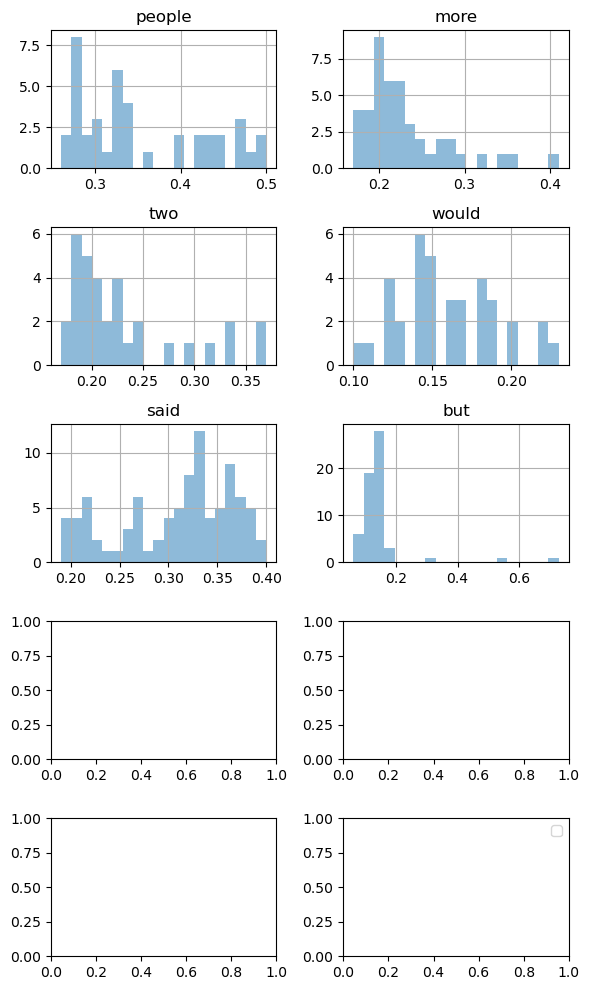

In [313]:
# plot durations of the top 10 words--one for each word 
# top_words = df_word['label'].value_counts().head(20).index.tolist()
top_words = ['people', 'more', 'two', 'would', 'said', 'but']
df_word[df_word['label'].isin(top_words)]

fig, axs = plt.subplots(5, 2, figsize=(6,10), tight_layout=False)
for word, ax  in zip(top_words, axs.ravel()):
    df_word[df_word['label'] == word]['duration'].hist(bins=20, alpha=0.5, label=word, ax=ax)
    ax.set_title(f'{word}')
plt.legend()

✅ Found 16883 segments matching query.


array([[<Axes: title={'center': 'start_time'}>,
        <Axes: title={'center': 'end_time'}>],
       [<Axes: title={'center': 'duration'}>, <Axes: >]], dtype=object)

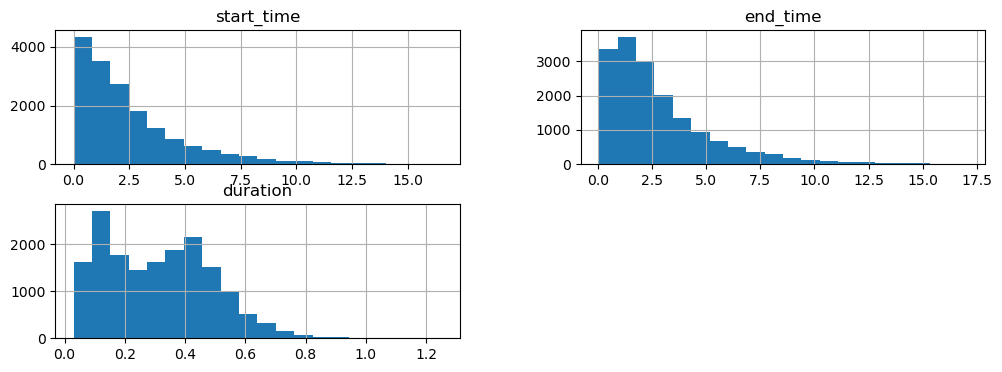

In [314]:
# query all tokens of the word "GREAT"
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="people"') 
df_result = query_segments(index_csv, 'segment_tier=="WORD"') 

# plot histograms start, stop, and duration columns from df_result
df_result[['start_time', 'end_time', 'duration']].hist(bins=20, figsize=(12,4))

# Plot trajectories

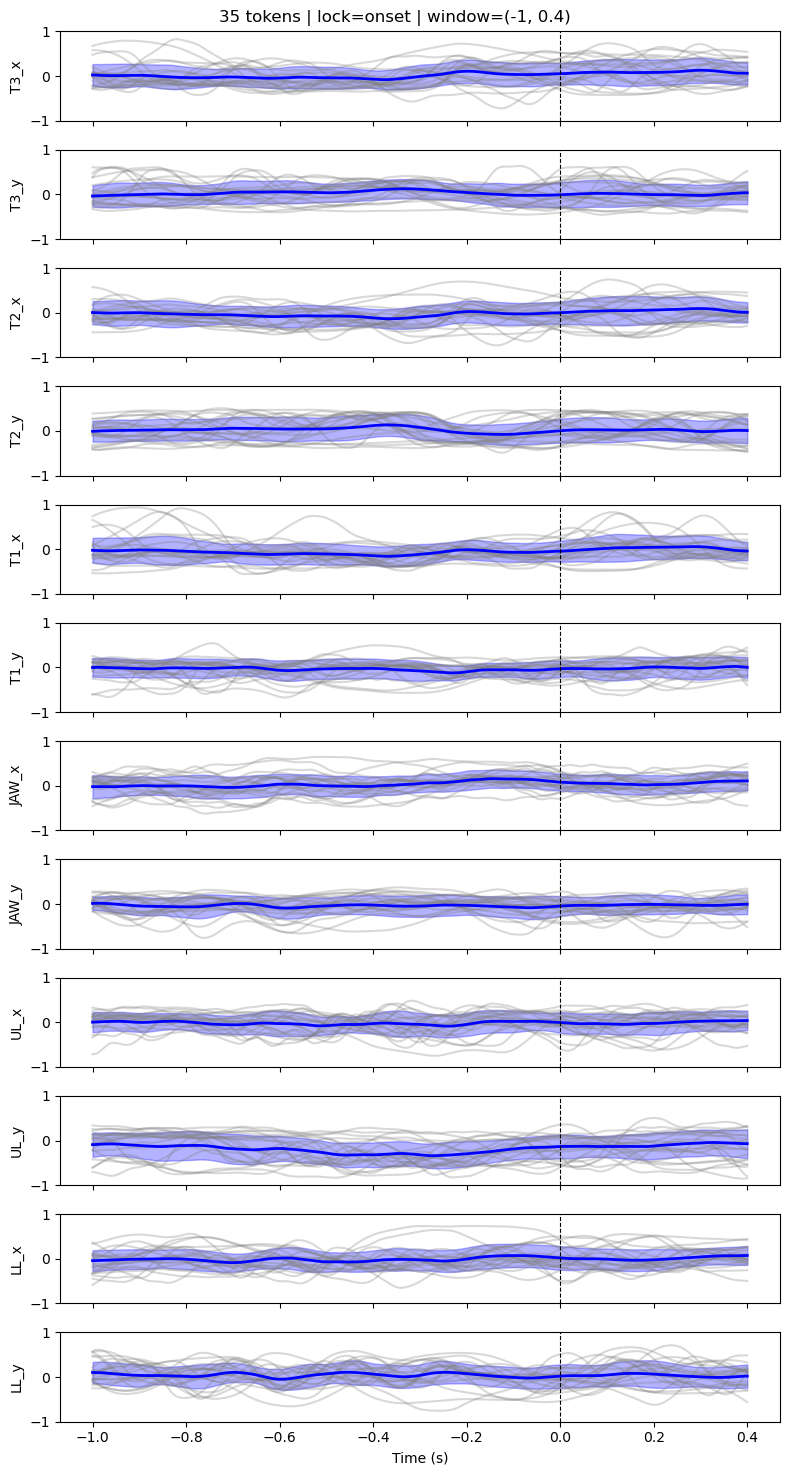

In [50]:
# plot articulatory trajectories aligned to onset
data_stack, t_common, chans = load_ema_traces(df_result, ema_dir, time_lock, WINDOW)
n_inst, n_chans, n_timepoints = data_stack.shape

plot_segments(df_result, ema_dir, time_lock="onset", WINDOW=(-1, 0.4), show_individual=True, ylims=[-1, 1])

In [33]:
df_result

,utterance_id,segment_tier,segment_id,label,start_time,end_time,duration,textgrid_path
185,mngu0_s1_0036,WORD,mngu0_s1_0036_word-010,said,2.41,2.74,0.33,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
289,mngu0_s1_0058,WORD,mngu0_s1_0058_word-007,said,1.54,1.88,0.34,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
387,mngu0_s1_0064,WORD,mngu0_s1_0064_word-003,said,0.55,0.76,0.21,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
1054,mngu0_s1_0100,WORD,mngu0_s1_0100_word-003,said,0.63,0.89,0.26,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
1506,mngu0_s1_0112,WORD,mngu0_s1_0112_word-008,said,1.90,2.25,0.35,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
2431,mngu0_s1_0265,WORD,mngu0_s1_0265_word-011,said,3.30,3.50,0.20,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
2885,mngu0_s1_0273,WORD,mngu0_s1_0273_word-012,said,3.22,3.55,0.33,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
3041,mngu0_s1_0289,WORD,mngu0_s1_0289_word-012,said,2.62,2.93,0.31,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
3416,mngu0_s1_0306,WORD,mngu0_s1_0306_word-003,said,0.46,0.84,0.38,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...
3645,mngu0_s1_0314,WORD,mngu0_s1_0314_word-004,said,0.78,1.04,0.26,/Users/ly546/Documents/data/mngu0_s1_TextGrid/...


# Reproduce PC decomposition

In [271]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

✅ Found 16883 segments matching query.


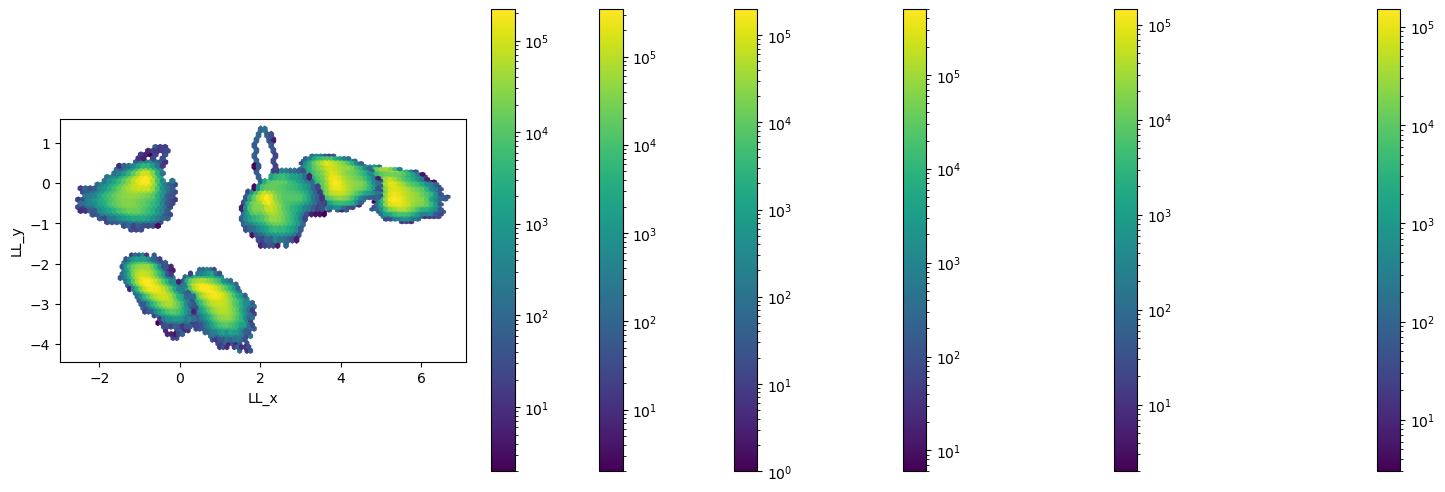

In [ ]:
df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="said"') 

ema_da = load_ema_traces(df_result, ema_dir, time_lock='middle', WINDOW=[-1, 1])

fig, ax = plt.subplots(figsize=(20,6))
for art in ARTIC_LABELS:
    norm_x = EMA_META.loc[EMA_META['name']==f'{art}_x', ['mean', 'std']]
    df[f'{art}_x'] = df[f'{art}_x'] + norm_x['mean'].values

    norm_y = EMA_META.loc[EMA_META['name']==f'{art}_y', ['mean', 'std']]
    df[f'{art}_y'] = df[f'{art}_y'] + norm_y['mean'].values

    df.plot.hexbin(x=f'{art}_x',
                    y=f'{art}_y',
                    gridsize=20,
                    cmap="viridis", 
                    bins='log',
                    ax=ax)
    # ax.colorbar().remove()
ax.set_aspect('equal', 'box')

In [286]:
emaall_df = ema_da.stack(allsamples=('rep','time')).T.to_pandas().reset_index(drop=True) # .drop('allsamples', axis=1)


# z-score each channel
scaler = StandardScaler()
X = scaler.fit(emaall_df)
X = scaler.transform(emaall_df)

# ---- PCA on full data ----
pca_all = PCA(n_components=emaall_df.shape[1])
pca_all = pca_all.fit(X)



In [282]:
X_pc = pca_all.transform(X)
X_pc

array([[ 2.86769995,  1.56720508, -3.35736984, ...,  0.7798196 ,
         0.03393853, -0.29665476],
       [ 2.79847878,  1.63141502, -3.35390189, ...,  0.80334778,
         0.02789264, -0.29316454],
       [ 2.72898075,  1.69585981, -3.34846858, ...,  0.82517961,
         0.02188153, -0.28992938],
       ...,
       [-0.04989081, -4.66119178, -0.11550293, ...,  0.07418424,
         0.01095381,  0.07426476],
       [-0.05127525, -4.65979229, -0.11571282, ...,  0.07436568,
         0.01048035,  0.07474652],
       [-0.05265969, -4.65839279, -0.1159227 , ...,  0.07454712,
         0.01000689,  0.07522829]], shape=(6025827, 12))

/Users/ly546/Documents/conda-miniforge3/envs/aligner/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Test time warping 

In [393]:
# xarray sandbox
aa = X_new.reset_index('allsamples').isel(allsamples=np.arange(15))
aa[2, 5] = np.nan
aa[3, 7] = np.nan
aa[3, 8] = np.nan
aa.isnull().sum()

# aa.where(aa > 0.5, 0, aa)
aa.where(~aa.isnull(), other=0)

aa.isel(allsamples=~aa.isnull().any(dim='chan'))

<xarray.DataArray (allsamples: 13, chan: 12)> Size: 1kB
array([[-1.16849229e-01, -2.99665958e-01, -1.17882356e-01,
        -2.40876347e-01, -2.70001620e-01, -2.62244105e-01,
         1.66899450e-02, -2.37244852e-02, -6.61191881e-01,
        -5.56432009e-01, -6.90752491e-02,  5.46786971e-02],
       [-7.98051678e-02, -3.08944394e-01, -7.92580168e-02,
        -2.42486965e-01, -2.27504260e-01, -2.64977796e-01,
         2.49723834e-02, -2.87893843e-02, -6.49645614e-01,
        -6.15691661e-01, -7.51207557e-02,  7.94700748e-02],
       [ 2.82716022e-02, -3.36188919e-01,  3.19117208e-02,
        -2.50598878e-01, -1.09554348e-01, -2.80462950e-01,
         2.39814868e-02, -2.65402911e-02, -6.14988615e-01,
        -7.72257045e-01, -9.96584620e-02,  1.87945612e-01],
       [ 5.98012943e-02, -3.45644427e-01,  6.45144356e-02,
        -2.55156904e-01, -7.52459687e-02, -2.86583962e-01,
         1.34333530e-02, -2.13957574e-02, -6.15708125e-01,
        -8.07845673e-01, -1.13826766e-01,  2.27313855e-01],
       [ 8.85962152e-02, -3.55422536e-01,  9.44003576e-02,
        -2.60745341e-01, -4.30504843e-02, -2.92365504e-01,
         2.01282890e-04, -1.52431824e-02, -6.26009754e-01,
        -8.32994909e-01, -1.32306860e-01,  2.64068678e-01],
...
       [ 1.86869630e-01, -3.94860783e-01,  1.94780869e-01,
        -2.91808324e-01,  7.19163428e-02, -3.16415212e-01,
        -4.51312448e-02,  6.28057275e-03, -7.28876318e-01,
        -8.59843884e-01, -2.39444301e-01,  3.56153377e-01],
       [ 2.10817778e-01, -4.03674455e-01,  2.18267373e-01,
        -3.00833189e-01,  9.80362819e-02, -3.23986554e-01,
        -5.55493974e-02,  9.86762763e-03, -7.52213757e-01,
        -8.61444390e-01, -2.65203848e-01,  3.66095149e-01],
       [ 2.35447398e-01, -4.11714247e-01,  2.42028570e-01,
        -3.09745981e-01,  1.23441647e-01, -3.31482153e-01,
        -6.79507757e-02,  1.29934059e-02, -7.69279693e-01,
        -8.64037670e-01, -2.85972314e-01,  3.72815904e-01],
       [ 2.60870967e-01, -4.18839853e-01,  2.66240815e-01,
        -3.18118017e-01,  1.48429288e-01, -3.38073486e-01,
        -8.25672947e-02,  1.57244422e-02, -7.79086019e-01,
        -8.67453186e-01, -3.00023224e-01,  3.77159238e-01],
       [ 2.87009138e-01, -4.24925995e-01,  2.90931177e-01,
        -3.25494701e-01,  1.73312595e-01, -3.42946571e-01,
        -9.86360252e-02,  1.79798994e-02, -7.81402874e-01,
        -8.70932722e-01, -3.06349152e-01,  3.79605526e-01]])
Coordinates:
  * chan     (chan) <U5 240B 'T3_x' 'T3_y' 'T2_x' ... 'UL_y' 'LL_x' 'LL_y'
    rep      (allsamples) int64 104B 0 0 0 0 0 0 0 0 0 0 0 0 0
    time     (allsamples) float64 104B -0.7 -0.695 -0.68 ... -0.64 -0.635 -0.63
Dimensions without coordinates: allsamples

In [372]:
# plt.imshow(np.isnan(X_new.reset_index('allsamples'))) # plot(robust=True)
# np.isnan(12)
X_new.isnull().sum()
# plt.imshow(np.isnan(X_new), aspect='auto', interpolation='nearest', cmap='gray_r')


<xarray.DataArray ()> Size: 8B
array(5)

# Plot segments with heatmap for each articulator

In [ ]:
df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="b"') 
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="money"') 

ema_da = load_ema_traces(df_result, ema_dir, time_lock='offset', WINDOW=[-0.250, 0.250], remove_nan=True)
ema_da = ema_da.where(~ema_da.isnull(), other=0) # set nan to 0

# # optionally, apply PCA 
# ema_stacked = ema_da.stack(allsamples=("rep", "time"))  # (chan, allsamples)
# X_new = ema_stacked.T  # (allsamples, chan)
# X_scaled = scaler.transform(X_new)  # (allsamples, chan)
# X_pca = pca_all.transform(X_scaled)  # shape: (allsamples, n_components)
# n_rep = ema_da.sizes["rep"]
# n_time = ema_da.sizes["time"]
# n_pc = X_pca.shape[1]

# # unstack back into (rep, time)
# X_pca_unstacked = X_pca.T.reshape(n_pc, n_rep, n_time)

# ema_pc_da = xr.DataArray(f
#     X_pca_unstacked,
#     dims=("chan", "rep", "time"),
#     coords={
#         "chan": [f'PC_{i}' for i in np.arange(1, n_pc + 1)],
#         "rep": ema_da.coords["rep"],
#         "time": ema_da.coords["time"],
#     },
#     name="ema_pca",
# )
# ema_da = ema_pc_da.transpose('rep','chan','time')

g = ema_da.diff('time', n=1).plot(col='chan', col_wrap=2, aspect=2, robust=True) # figsize=(8, 15),
for ax in g.axs.flat:
    # Add a vertical line at x=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=2.5)
    

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3062545399.py, line 19)

# Define dtw_barycenter

In [579]:
from scipy.signal import savgol_filter

def _init_template_medoid(data, gdtw, params, sample=20):
    # data: (N,C,T). Pick a small subset to find an approximate medoid.
    N, C, T = data.shape
    idxs = np.linspace(0, N-1, min(N, sample), dtype=int)
    costs = np.zeros(len(idxs))
    for i, ii in enumerate(idxs):
        ci = 0.0
        for jj in idxs:
            if jj == ii: 
                continue
            _, _, cost, _ = gdtw.warp(data[jj], data[ii], params=params)
            ci += cost
        costs[i] = ci
    seed = data[idxs[np.argmin(costs)]].copy()
    return seed

def _zscore_token(tok):
    # tok: (C,T)
    mu = tok.mean(axis=1, keepdims=True)
    sd = tok.std(axis=1, keepdims=True)
    sd[sd == 0] = 1.0
    return (tok - mu) / sd

def _resample_to_grid(Y, target_len):
    # Y: (C, t_len). Resample each channel to target_len via linear interp
    Y = Y.squeeze()
    C, L = Y.shape
    x_old = np.linspace(0, 1, L)
    x_new = np.linspace(0, 1, target_len)
    out = np.empty((C, target_len))
    for c in range(C):
        out[c] = np.interp(x_new, x_old, Y[c])
    return out


def dtw_barycenter_multichannel(
    X,                      # (N, C, T)
    gdtw,                   # module or object with .warp(X, Y, params)
    params,                 # dict for gdtw
    n_iter=6,
    lips_channels=None,     # list of channel indices to emphasize, e.g. ULx, ULy, LLx, LLy, JAWx, JAWy
    init_mode='medoid',     # or 'lips_mean'
    smooth_template=True,
    smooth_win=7, smooth_poly=2,
    verbose=True
):
    """
    Returns:
        template  : (C,T) prototype
        warped    : list of (C,T) tokens warped to template
        phis      : list of warping functions (implementation-dependent)
        costs     : array of DTW costs
        ch_weights: (C,) channel weights used on last iteration
        tk_weights: (N,) token weights used on last iteration
    """
    N, C, T = X.shape
    # z-score per token per channel (optional but helpful)
    # Xz = np.stack([_zscore_token(X[k]) for k in range(N)], axis=0)
    Xz = X.copy()

    # init template
    if init_mode == 'medoid':
        template = _init_template_medoid(Xz, gdtw, params)
    elif init_mode == 'lips_mean' and lips_channels is not None and len(lips_channels) > 0:
        # average lips/jaw channels; for others copy from closest token later
        temp = Xz[:, lips_channels, :].mean(axis=0)
        # find token closest (DTW) to this partial template (using only lips channels)
        costs = []
        for k in range(N):
            _, _, cost, _ = gdtw.warp(Xz[k, lips_channels, :], temp, params=params)
            costs.append(cost)
        best = int(np.argmin(costs))
        template = Xz[best].copy()
        template[lips_channels] = temp
    else:
        template = Xz[0].copy()

    ch_weights = np.ones(C)
    tk_weights = np.ones(N)

    for it in range(n_iter):
        warped = []
        phis   = []
        costs  = []

        # align each token to current template
        for k in range(N):
            phi, Yw, cost, _ = gdtw.warp(Xz[k], template, params=params)
            Yw = _resample_to_grid(Yw, T)
            warped.append(Yw)
            phis.append(phi)
            costs.append(cost)

        warped = np.stack(warped, axis=0)   # (N,C,T)
        costs  = np.asarray(costs)

        # update token weights (downweight outliers)
        # robust weights ~ inverse cost, clipped
        eps = 1e-6
        inv = 1.0 / (costs + eps)
        inv /= inv.mean()
        tk_weights = np.clip(inv, 0.3, 3.0)

        # update channel weights (lower across-token variance -> higher weight)
        var_ct = warped.var(axis=0)          # (C,T)
        var_c  = var_ct.mean(axis=1)         # (C,)
        invc   = 1.0 / (var_c + 1e-6)
        invc  /= invc.mean()
        ch_weights = np.clip(invc, 0.5, 3.0)

        # optional manual boost for lips/jaw
        if lips_channels:
            ch_weights[lips_channels] *= 1.5

        # compute weighted average template
        # weights: (N,1,1)*(1,C,1) -> (N,C,T)
        W = tk_weights[:, None, None] * ch_weights[None, :, None]
        template_new = (W * warped).sum(axis=0) / (W.sum(axis=0) + 1e-8)

        if smooth_template:
            for c in range(C):
                template_new[c] = savgol_filter(template_new[c], window_length=min(smooth_win, T - (1 - smooth_win % 2)), polyorder=smooth_poly, mode='interp')

        # check convergence
        delta = np.linalg.norm(template_new - template) / (np.linalg.norm(template) + 1e-8)
        template = template_new
        if verbose:
            print(f"iter {it+1}/{n_iter}: mean cost={costs.mean():.4f}, Δ={delta:.4f}")

        if delta < 1e-3:
            break
        
        # warped_stacked = np.stack(warped, axis=0)
    return template, warped, phis, costs, ch_weights, tk_weights


In [599]:
df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="k"') 
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="said"') 

ema_da = load_ema_traces(df_result, ema_dir, time_lock='middle', WINDOW=[-0.7, 0.7], remove_nan=True)


dtw_params = {
"lambda_cum": 0.1, 
"lambda_inst": 0.1,
"Loss": "cosine"
}

[template, warped, phis, costs, ch_weights, tk_weights] = dtw_barycenter_multichannel(
    ema_da.values,                      # (N, C, T)
    gdtw,                   # module or object with .warp(X, Y, params)
    dtw_params,                 # dict for gdtw
    n_iter=6,
    init_mode='medoid',     # or 'lips_mean'
    smooth_template=True,
    smooth_win=7, smooth_poly=2,
    verbose=True
)

ema_warped_da = ema_da.copy()
ema_warped_da.values = warped

template_da = ema_da.mean(dim='rep')
template_da.values = template 

✅ Found 773 segments matching query.
Removing 0 out of 697 segments with NaN values.
iter 1/6: mean cost=1.7501, Δ=0.7000
iter 2/6: mean cost=1.6619, Δ=0.7221
iter 3/6: mean cost=1.6400, Δ=0.3918
iter 4/6: mean cost=1.6162, Δ=0.1352
iter 5/6: mean cost=1.6060, Δ=0.1103
iter 6/6: mean cost=1.6019, Δ=0.0830


In [600]:
ch_weights

array([0.61275613, 0.91729641, 1.07377873, 1.14642997, 1.16765847,
       1.17834619, 1.24223341, 1.16528767, 1.11298602, 0.92226474,
       0.90022324, 0.56073902])

In [623]:
# TRY SIMPLE MEAN template
dtw_params = {
"lambda_cum": 1, 
"lambda_inst": 0.1,
"Loss": "cosine"
}

template_da = ema_da.mean(dim='rep')
ema_warped_da = ema_da.copy()
for i, X in enumerate(ema_da): 
    # print(template_da.values.squeeze())
    phi, Xw, cost, _ = gdtw.warp(X.values.squeeze(),template_da.values.squeeze(), params=dtw_params)
    ema_warped_da[i, :, :] = Xw.squeeze()


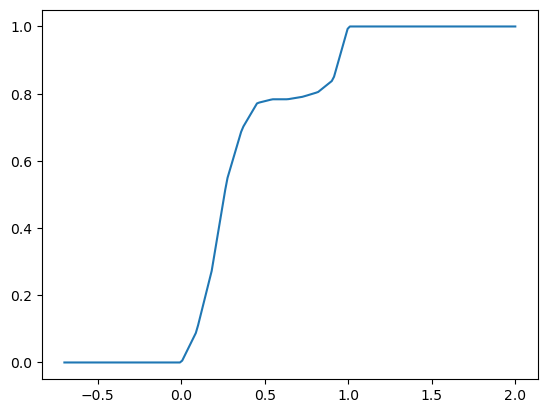

In [624]:
t = np.linspace(-0.7, 2, 200)
plt.plot(t, phi(t))

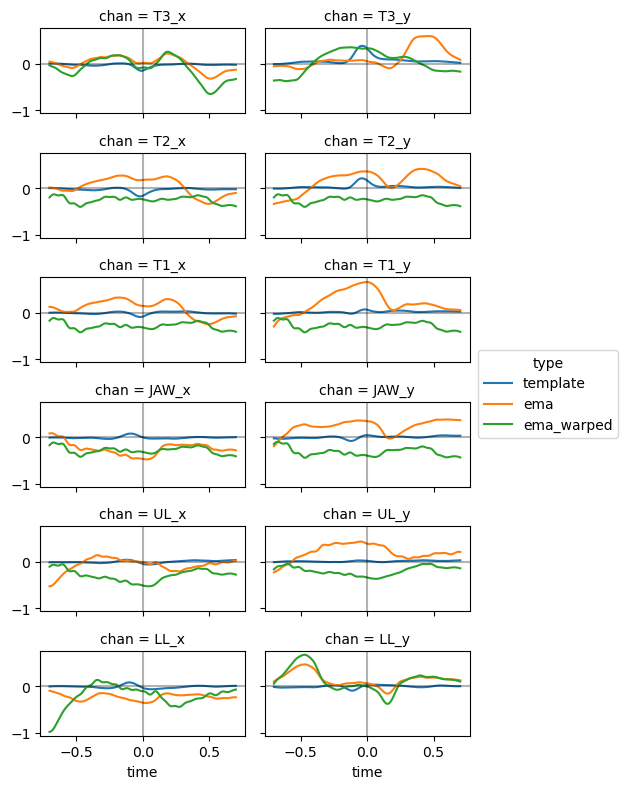

In [625]:
idx = 101
# xr.concat([template_da, ema_da.isel(rep=idx), ema_warped_da.isel(rep=idx)], 'type').plot(col='chan', col_wrap=2, hue='type')

da = xr.concat(
    [template_da, ema_da.isel(rep=idx), ema_warped_da.isel(rep=idx)],
    dim=pd.Index(['template', 'ema', 'ema_warped'], name='type')
)
g = da.plot(col='chan', col_wrap=2, hue='type', figsize=(5, 8), aspect=2)
for ax in g.axs.flat: 
    ax.axvline(x=0, color='k', alpha=0.3)
    ax.axhline(y=0, color='k', alpha=0.3)

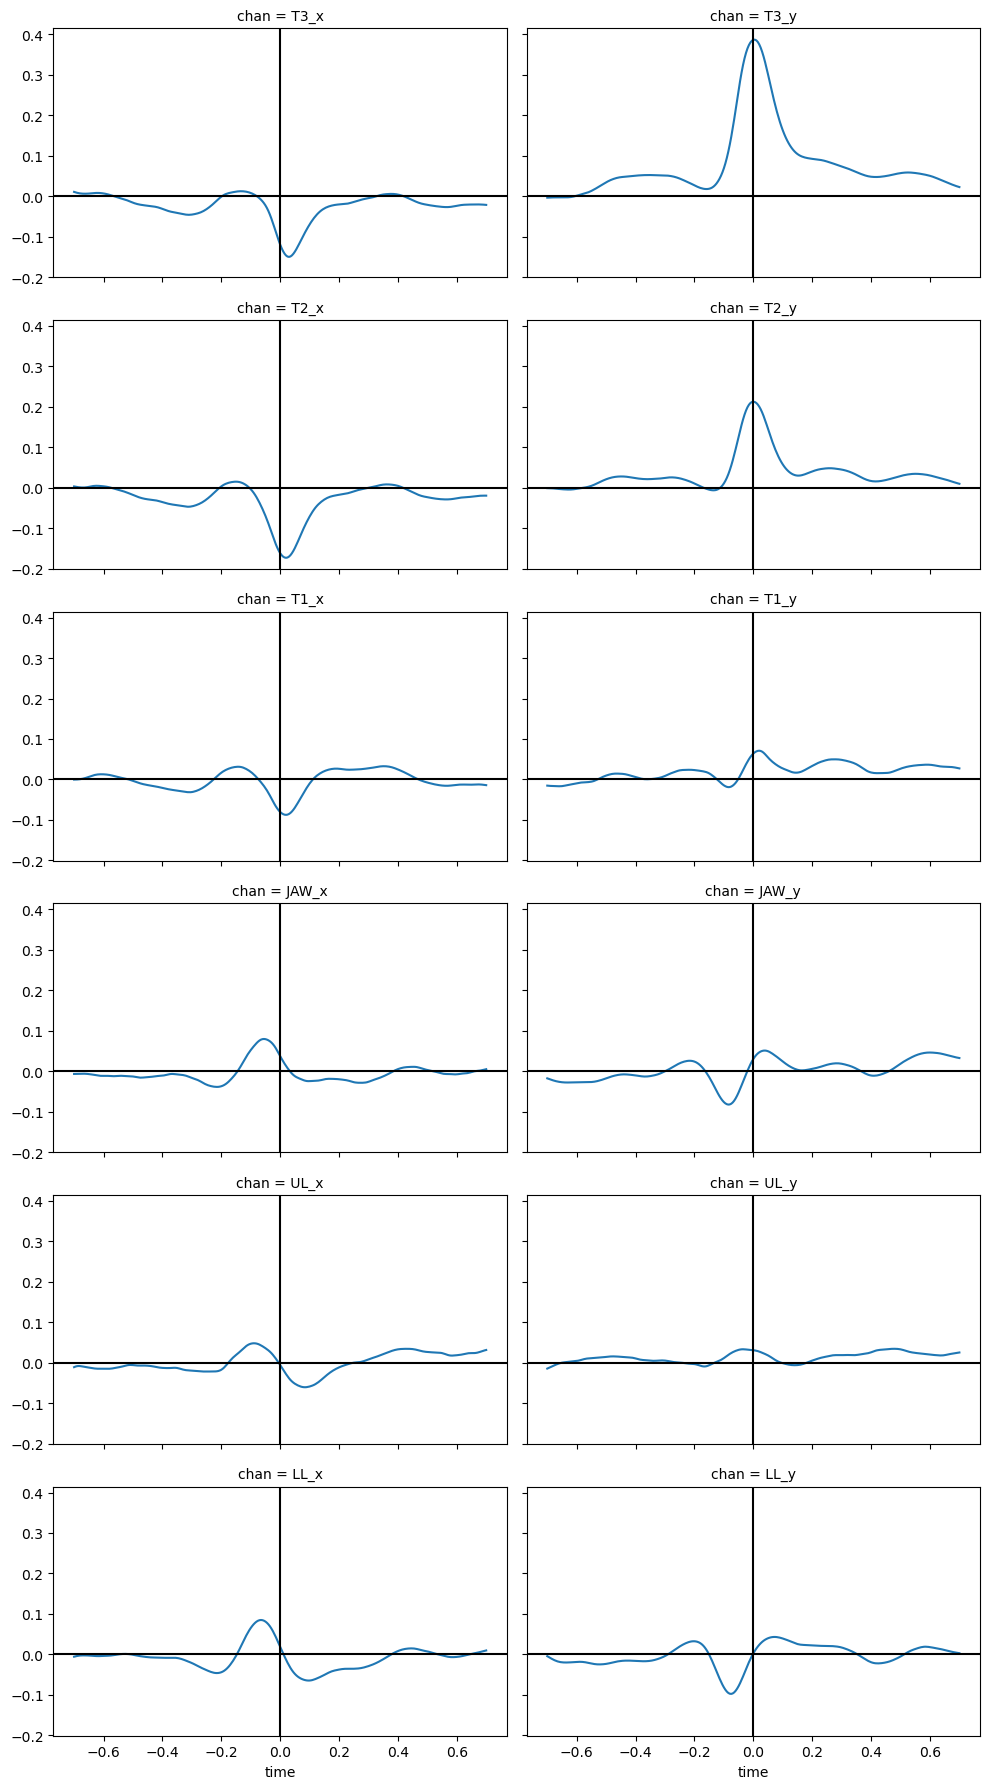

In [557]:
g = ema_da.mean(dim='rep').plot(col='chan', col_wrap=2, aspect=1.5)
for ax in g.axs.flat: 
    ax.axvline(x=0, color='k')
    ax.axhline(y=0, color='k')

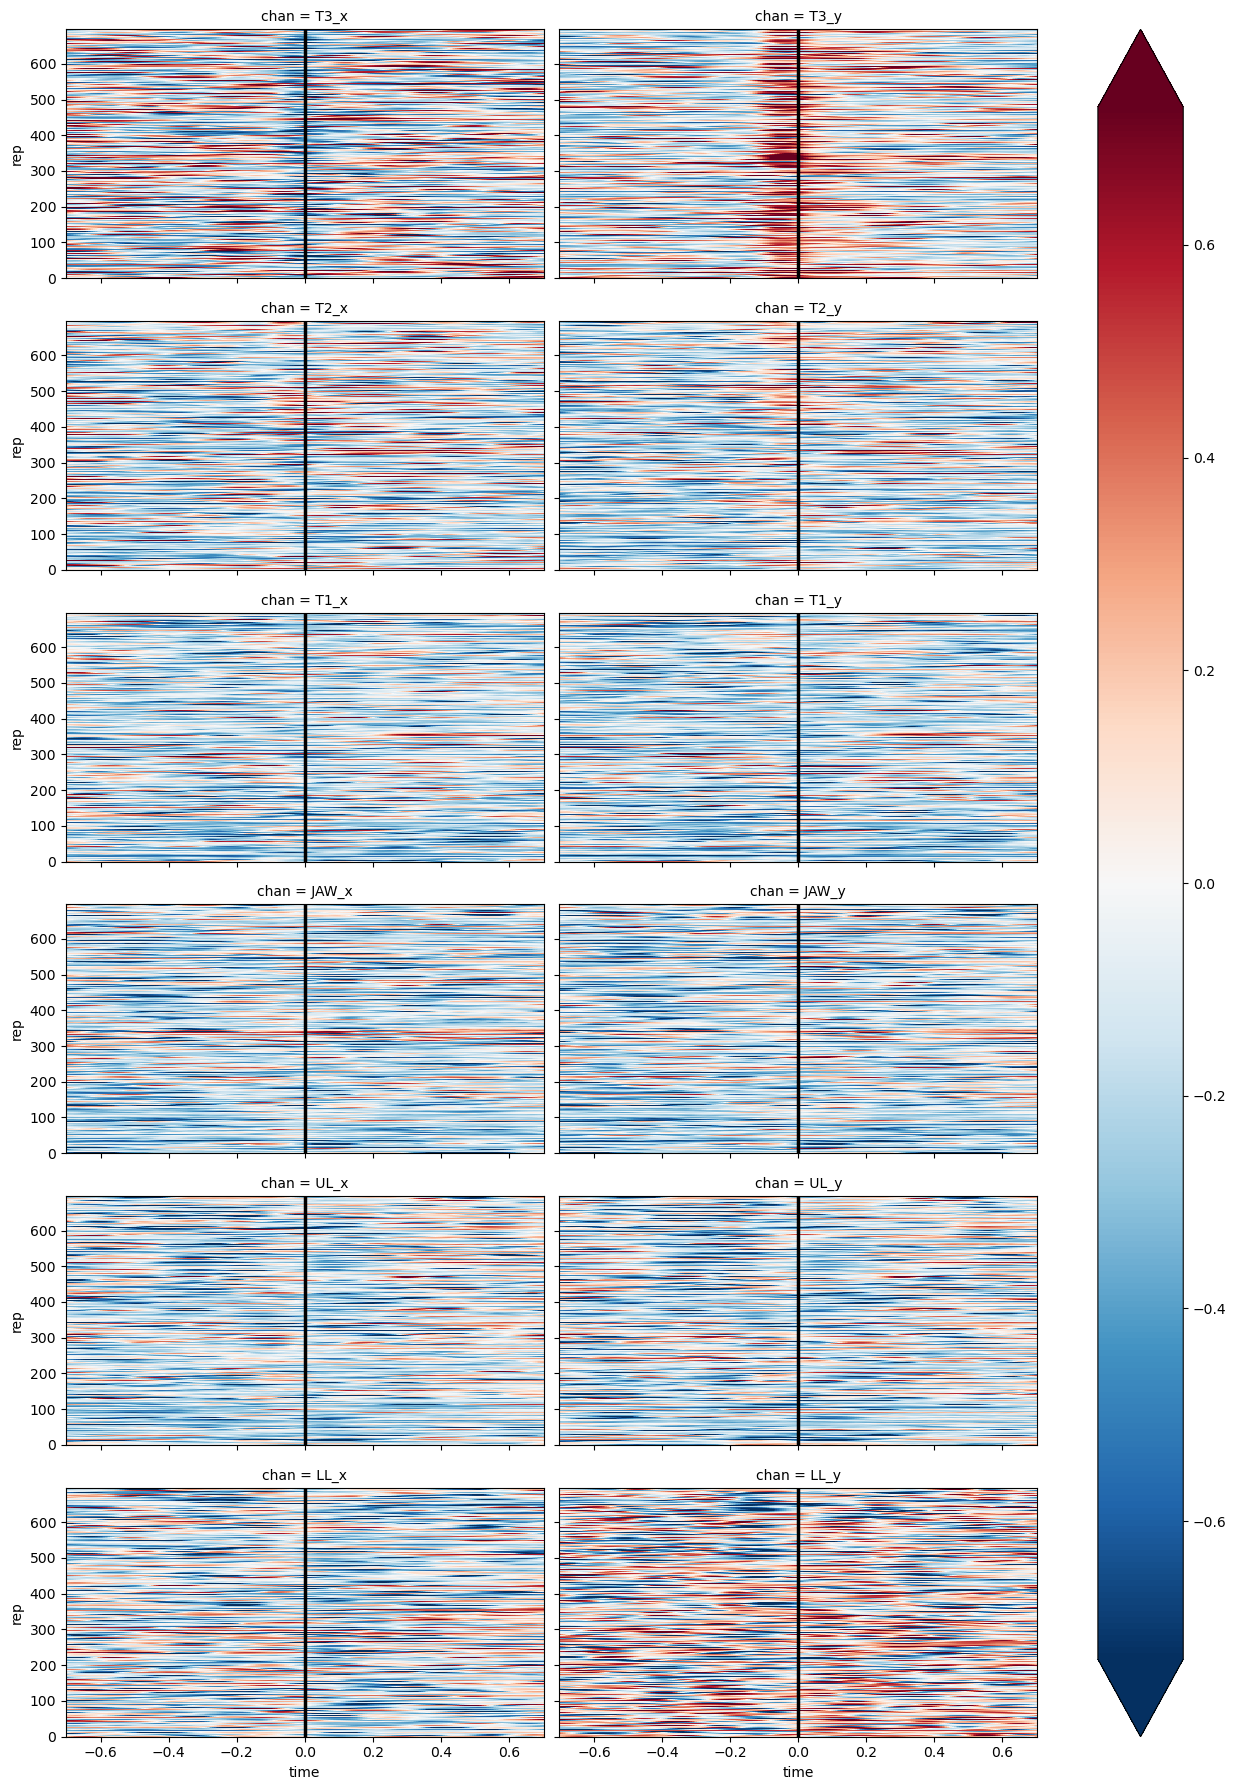

In [619]:
# da = xr.DataArray(template, coords={"chan": t_common, "chan": chans}, dims=("rep","chan","time"))
# xr.DataArray(warped).assign_coords(ema_da.coords)
# ema_warped_da = ema_da.copy()
# ema_warped_da.values = warped

g = ema_warped_da.plot(col='chan', col_wrap=2, aspect=2, robust=True) # figsize=(8, 15),
for ax in g.axs.flat:
    # Add a vertical line at x=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=2.5)



In [448]:
len(warped)
warped[2].shape

(12, 281)

In [626]:
plot_segments(ema_da)

NameError: name 'n_chans' is not defined

In [ ]:


X, Y = ema_da.sel(rep=21), ema_da.sel(rep=25)
# print('input shapes: ', c["mfcc_delta"].T.shape, target["mfcc_delta"].T.shape)
[phi, Y_warped, cost, g] = gdtw.warp(X.values, Y.values, params=params)

plot_df = pd.DataFrame({'X':X, 'Y':Y, 'Y_warped':Y_warped})
# plot X, Y, and Y_warped
plt.figure(figsize=(10,6))
plot_df.plot()


ValueError: Per-column arrays must each be 1-dimensional